<a href="https://colab.research.google.com/github/tomiokario/SimpleNeuralArchitectureSearchWithOptuna/blob/main/SimpleNeuralArchitectureSearchWithOptuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Neural Architecture Search with Optuna
簡易な設定でOptunaによるNAS（Neural Architecture Search）を行う勉強用のプログラム
- Fasion MNIST画像識別課題に対して全結合型ニューラルネットワークの最適な構造を探索する
- TPE(Tree-structured Parzen Estimator)アルゴリズムにより，検証時の損失を最小化する(1)層数，(2)各層のパラメータ数，(3)学習率，(4)バッチサイズを探索する．

※このコードでは，乱数設定より良い結果が得られるとは限らない


## パッケージの導入

In [1]:
! pip install optuna
!pip install optuna-integration[tfkeras]

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import TFKerasPruningCallback

import optuna
import optuna.visualization as vis

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random, math

## NASの実行

In [3]:
# --- データセットの読み込みと前処理 ---
def load_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32")  / 255.0
    # 一部を検証用に分割（例：最後の1万件）
    x_train, x_val = x_train[:-10000], x_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = load_data()

# --- ハイパーパラメータの探索空間を定義する関数 ---
def define_search_space(trial):
    """
    この関数は、Optuna の trial を利用して
    最適化するハイパーパラメータを明示的に辞書形式で定義します。
    """
    params = {}

    # モデル構造に関するパラメータ
    params["n_layers"] = trial.suggest_int("n_layers", 1, 5)
    params["layers"] = []
    for i in range(params["n_layers"]):
        # 各 Dense 層のユニット数（32～512, 32 刻み）
        units = trial.suggest_int(f"n_units_l{i}", 32, 512, step=32)
        params["layers"].append(units)

    # 学習率（対数スケールで探索）
    params["lr"] = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    # バッチサイズ（32～128の整数値）
    # params["batch_size"] = trial.suggest_int("batch_size", 32, 128, step=32)

    return params

# --- モデル作成関数 ---
def create_model(params):
    """
    define_search_space() で得たパラメータを使ってモデルを作成します。
    """
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    for units in params["layers"]:
        model.add(Dense(units, activation="relu"))

    model.add(Dense(10, activation="softmax"))

    optimizer = Adam(learning_rate=params["lr"])
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# --- 目的関数 ---
def objective(trial):
    # ハイパーパラメータの探索空間を明示的に定義し、辞書として取得
    params = define_search_space(trial)

    # パラメータに基づいてモデルを作成
    model = create_model(params)

    # コールバックの設定
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
    # pruning_callback = TFKerasPruningCallback(trial, "val_loss")

    epochs = 20  # 必要に応じて調整

    # モデルの学習
    model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=32,
        # batch_size=params["batch_size"],
        # callbacks=[early_stopping, pruning_callback],
        callbacks=[early_stopping],
        verbose=0
    )

    # 検証データで評価
    score = model.evaluate(x_val, y_val, verbose=0)
    # 検証損失を目的関数として返す
    return score[0]

# --- メイン処理 ---
if __name__ == "__main__":
    # 最小化問題として Study を作成
    study = optuna.create_study(direction="minimize")
    # 例として 30 試行で最適化
    study.optimize(objective, n_trials=30)

    print("=== 最適なハイパーパラメータ ===")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")
    print(f"最適な検証損失: {study.best_trial.value:.4f}")


[I 2025-02-02 08:16:28,166] A new study created in memory with name: no-name-2e1e5447-b4c6-48d8-bcb2-268656526a23
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-02-02 08:18:21,853] Trial 0 finished with value: 0.3907945156097412 and parameters: {'n_layers': 3, 'n_units_l0': 32, 'n_units_l1': 416, 'n_units_l2': 320, 'lr': 2.3020877119586296e-05}. Best is trial 0 with value: 0.3907945156097412.


Epoch 9: early stopping


[I 2025-02-02 08:19:39,392] Trial 1 finished with value: 0.5207171440124512 and parameters: {'n_layers': 5, 'n_units_l0': 32, 'n_units_l1': 480, 'n_units_l2': 512, 'n_units_l3': 32, 'n_units_l4': 160, 'lr': 0.005923640626526916}. Best is trial 0 with value: 0.3907945156097412.
[I 2025-02-02 08:21:43,664] Trial 2 finished with value: 0.31030064821243286 and parameters: {'n_layers': 4, 'n_units_l0': 288, 'n_units_l1': 384, 'n_units_l2': 352, 'n_units_l3': 128, 'lr': 3.0235695398137017e-05}. Best is trial 2 with value: 0.31030064821243286.


Epoch 14: early stopping


[I 2025-02-02 08:23:24,261] Trial 3 finished with value: 0.3369460999965668 and parameters: {'n_layers': 4, 'n_units_l0': 32, 'n_units_l1': 160, 'n_units_l2': 384, 'n_units_l3': 224, 'lr': 0.00035509980407105236}. Best is trial 2 with value: 0.31030064821243286.


Epoch 15: early stopping


[I 2025-02-02 08:24:49,650] Trial 4 finished with value: 0.32117071747779846 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 160, 'n_units_l2': 160, 'lr': 0.00016927124679424574}. Best is trial 2 with value: 0.31030064821243286.


Epoch 8: early stopping


[I 2025-02-02 08:25:37,810] Trial 5 finished with value: 0.4298955202102661 and parameters: {'n_layers': 4, 'n_units_l0': 352, 'n_units_l1': 224, 'n_units_l2': 96, 'n_units_l3': 448, 'lr': 0.0044834186373040414}. Best is trial 2 with value: 0.31030064821243286.


Epoch 20: early stopping


[I 2025-02-02 08:27:21,441] Trial 6 finished with value: 0.3123840391635895 and parameters: {'n_layers': 4, 'n_units_l0': 512, 'n_units_l1': 480, 'n_units_l2': 448, 'n_units_l3': 192, 'lr': 2.8532164919527782e-05}. Best is trial 2 with value: 0.31030064821243286.


Epoch 12: early stopping


[I 2025-02-02 08:28:36,225] Trial 7 finished with value: 0.327717125415802 and parameters: {'n_layers': 5, 'n_units_l0': 480, 'n_units_l1': 512, 'n_units_l2': 448, 'n_units_l3': 480, 'n_units_l4': 416, 'lr': 0.00011182015131393244}. Best is trial 2 with value: 0.31030064821243286.
[I 2025-02-02 08:30:20,586] Trial 8 finished with value: 0.33730989694595337 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 64, 'lr': 2.5782126483716616e-05}. Best is trial 2 with value: 0.31030064821243286.


Epoch 18: early stopping


[I 2025-02-02 08:31:50,727] Trial 9 finished with value: 0.33236682415008545 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 192, 'n_units_l2': 480, 'lr': 3.91195526346507e-05}. Best is trial 2 with value: 0.31030064821243286.


Epoch 15: early stopping


[I 2025-02-02 08:33:04,481] Trial 10 finished with value: 0.3236640393733978 and parameters: {'n_layers': 1, 'n_units_l0': 224, 'lr': 0.0006886030643749537}. Best is trial 2 with value: 0.31030064821243286.
[I 2025-02-02 08:34:58,349] Trial 11 finished with value: 0.3425725996494293 and parameters: {'n_layers': 4, 'n_units_l0': 384, 'n_units_l1': 352, 'n_units_l2': 256, 'n_units_l3': 128, 'lr': 1.3517226062343755e-05}. Best is trial 2 with value: 0.31030064821243286.


Epoch 12: early stopping


[I 2025-02-02 08:36:02,563] Trial 12 finished with value: 0.33168545365333557 and parameters: {'n_layers': 4, 'n_units_l0': 224, 'n_units_l1': 352, 'n_units_l2': 320, 'n_units_l3': 256, 'lr': 6.797653553791645e-05}. Best is trial 2 with value: 0.31030064821243286.
[I 2025-02-02 08:38:20,480] Trial 13 finished with value: 0.3480205833911896 and parameters: {'n_layers': 5, 'n_units_l0': 448, 'n_units_l1': 416, 'n_units_l2': 384, 'n_units_l3': 160, 'n_units_l4': 32, 'lr': 1.0304407580631573e-05}. Best is trial 2 with value: 0.31030064821243286.


Epoch 12: early stopping


[I 2025-02-02 08:39:26,850] Trial 14 finished with value: 0.3216492235660553 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 320, 'n_units_l2': 224, 'lr': 0.0007796216305637198}. Best is trial 2 with value: 0.31030064821243286.


Epoch 19: early stopping


[I 2025-02-02 08:40:57,594] Trial 15 finished with value: 0.3098045885562897 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 448, 'lr': 5.395790834052842e-05}. Best is trial 15 with value: 0.3098045885562897.
[I 2025-02-02 08:42:32,501] Trial 16 finished with value: 0.3168458640575409 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'lr': 6.238702704291272e-05}. Best is trial 15 with value: 0.3098045885562897.


Epoch 13: early stopping


[I 2025-02-02 08:43:39,896] Trial 17 finished with value: 0.31405556201934814 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 416, 'lr': 0.0001843246484464704}. Best is trial 15 with value: 0.3098045885562897.


Epoch 10: early stopping


[I 2025-02-02 08:44:30,686] Trial 18 finished with value: 0.3647156357765198 and parameters: {'n_layers': 2, 'n_units_l0': 160, 'n_units_l1': 288, 'lr': 0.001980686636308069}. Best is trial 15 with value: 0.3098045885562897.


Epoch 16: early stopping


[I 2025-02-02 08:45:52,575] Trial 19 finished with value: 0.31564009189605713 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 384, 'lr': 6.877496425551017e-05}. Best is trial 15 with value: 0.3098045885562897.


Epoch 14: early stopping


[I 2025-02-02 08:47:03,137] Trial 20 finished with value: 0.30970653891563416 and parameters: {'n_layers': 1, 'n_units_l0': 224, 'lr': 0.0003691429734158385}. Best is trial 20 with value: 0.30970653891563416.


Epoch 16: early stopping


[I 2025-02-02 08:48:20,721] Trial 21 finished with value: 0.3076871633529663 and parameters: {'n_layers': 1, 'n_units_l0': 224, 'lr': 0.00042962968250750185}. Best is trial 21 with value: 0.3076871633529663.


Epoch 9: early stopping


[I 2025-02-02 08:49:10,228] Trial 22 finished with value: 0.3231489956378937 and parameters: {'n_layers': 1, 'n_units_l0': 192, 'lr': 0.0007532111252766141}. Best is trial 21 with value: 0.3076871633529663.
[I 2025-02-02 08:51:08,445] Trial 23 finished with value: 0.316516637802124 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'lr': 0.00035450424115326295}. Best is trial 21 with value: 0.3076871633529663.


Epoch 9: early stopping


[I 2025-02-02 08:52:00,620] Trial 24 finished with value: 0.3334973454475403 and parameters: {'n_layers': 1, 'n_units_l0': 224, 'lr': 0.0015056718034911502}. Best is trial 21 with value: 0.3076871633529663.


Epoch 14: early stopping


[I 2025-02-02 08:53:26,952] Trial 25 finished with value: 0.3098013997077942 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 32, 'lr': 0.000245511435678736}. Best is trial 21 with value: 0.3076871633529663.


Epoch 17: early stopping


[I 2025-02-02 08:55:00,420] Trial 26 finished with value: 0.3156585097312927 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'lr': 0.00021756260869379288}. Best is trial 21 with value: 0.3076871633529663.


Epoch 12: early stopping


[I 2025-02-02 08:56:03,792] Trial 27 finished with value: 0.3121950626373291 and parameters: {'n_layers': 2, 'n_units_l0': 160, 'n_units_l1': 32, 'lr': 0.0005042816064887972}. Best is trial 21 with value: 0.3076871633529663.


Epoch 11: early stopping


[I 2025-02-02 08:56:58,731] Trial 28 finished with value: 0.3427940309047699 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'lr': 0.0025320993808766686}. Best is trial 21 with value: 0.3076871633529663.


Epoch 10: early stopping


[I 2025-02-02 08:57:54,089] Trial 29 finished with value: 0.34878334403038025 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 96, 'lr': 0.0013536549349547724}. Best is trial 21 with value: 0.3076871633529663.


=== 最適なハイパーパラメータ ===
n_layers: 1
n_units_l0: 224
lr: 0.00042962968250750185
最適な検証損失: 0.3077


## プロット
- ハイパーパラメータ最適化の過程（各トライアルでの検証損失）を示すグラフを作成する。
- また、各パラメータの重要性を比較するグラフを作成する。

In [4]:
# --- 最適化履歴のプロット ---
history_fig = vis.plot_optimization_history(study)
history_fig.update_layout(
    title="Optimization History",
    xaxis_title="Trial",
    yaxis_title="Objective Value"
)
history_fig.show()

# --- パラメータ重要度のプロット ---
param_importance_fig = vis.plot_param_importances(study)
param_importance_fig.update_layout(
    title="Parameter Importances"
)
param_importance_fig.show()


## 検証
- ベストパラメータの結果を混同行列で確認する。
- また、ランダム生成した複数のパラメータと検証精度を棒グラフで比較する。

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


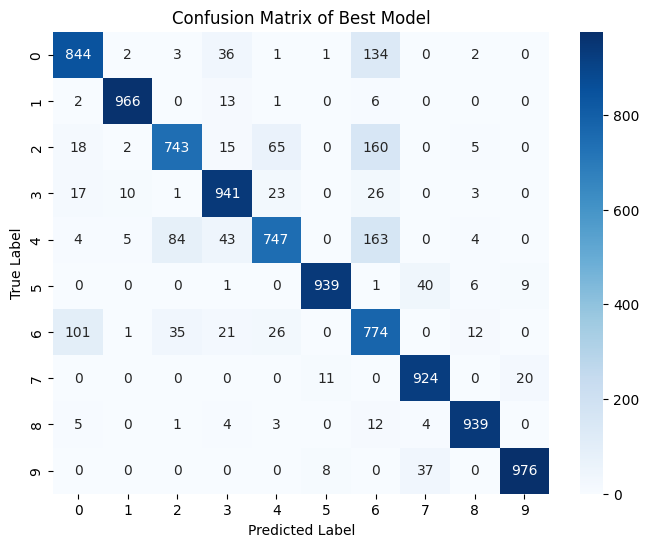

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

<ipython-input-7-6d63110a9115>:121: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




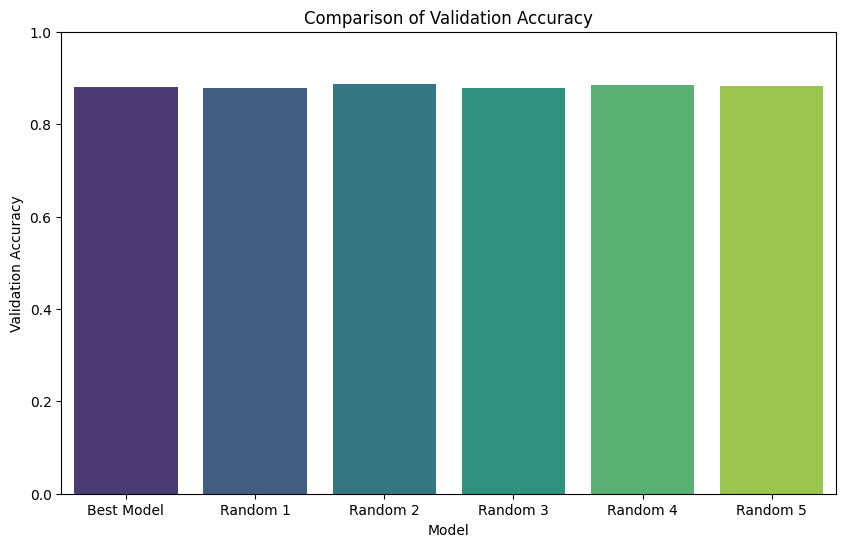

In [7]:
# ------------------------------
# Data Loading and Preprocessing
# ------------------------------
def load_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0
    # Use the last 10,000 samples of training data as validation data
    x_train, x_val = x_train[:-10000], x_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = load_data()

# ------------------------------
# Model Creation Function
# ------------------------------
def create_model(params):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    for units in params["layers"]:
        model.add(Dense(units, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    optimizer = Adam(learning_rate=params["lr"])
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ------------------------------
# Convert Best Trial Parameters from Optuna
# ------------------------------
def convert_best_params(trial_params):
    new_params = {}
    n_layers = trial_params["n_layers"]
    new_params["n_layers"] = n_layers
    layers = []
    for i in range(n_layers):
        layers.append(trial_params[f"n_units_l{i}"])
    new_params["layers"] = layers
    new_params["lr"] = trial_params["lr"]
    return new_params

# ------------------------------
# (1) Best Model: Training and Confusion Matrix
# ------------------------------
# Retrieve best parameters from the Optuna study
# (Ensure that 'study' exists; it should have been created and optimized previously.)
best_trial_params = study.best_trial.params
best_params = convert_best_params(best_trial_params)

# Create and train the best model
best_model = create_model(best_params)
early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=0)
best_model.fit(x_train, y_train,
               validation_data=(x_val, y_val),
               epochs=20,
               batch_size=32,
               callbacks=[early_stopping],
               verbose=0)
# Evaluate on validation data
score = best_model.evaluate(x_val, y_val, verbose=0)

# Generate predictions and compute the confusion matrix
y_pred_prob = best_model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Best Model")
plt.show()

# ------------------------------
# (2) Random Models: Validation Accuracy Comparison
# ------------------------------
def generate_random_params():
    """
    Generate random parameters within the search space:
      - Number of layers: 1 to 5
      - Units per layer: 32 to 512 (step size 32)
      - Learning rate: log-uniform between 1e-5 and 1e-2
      - Batch size: one of [32, 64, 96, 128]
    """
    params = {}
    params["n_layers"] = random.randint(1, 5)
    layers = []
    for _ in range(params["n_layers"]):
        layers.append(random.choice(list(range(32, 513, 32))))
    params["layers"] = layers
    log_lr = random.uniform(math.log10(1e-5), math.log10(1e-2))
    params["lr"] = 10 ** log_lr
    params["batch_size"] = random.choice([32, 64, 96, 128])
    return params

num_random = 5  # Number of random models
random_accuracies = []

for i in range(num_random):
    r_params = generate_random_params()
    model_r = create_model(r_params)
    model_r.fit(x_train, y_train,
                validation_data=(x_val, y_val),
                epochs=20,
                batch_size=r_params["batch_size"],
                callbacks=[EarlyStopping(monitor="val_loss", patience=3, verbose=0)],
                verbose=0)
    score_r = model_r.evaluate(x_val, y_val, verbose=0)
    random_accuracies.append(score_r[1])  # score_r[1] is validation accuracy

# Prepare data for the bar chart comparison
model_names = ["Best Model"] + [f"Random {i+1}" for i in range(num_random)]
accuracies = [score[1]] + random_accuracies

# Plot the comparison bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.title("Comparison of Validation Accuracy")
plt.show()
